#### Block 1:  Import general purpose packages for ease of use and improved performance.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pprint

#### Block 2:  Import packages for a typical deep learning workflow using TensorFlow and Keras.  Import the California housing market dataset from Keras.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import california_housing

####  Block 3:  Define functions called in subsequent blocks.

In [12]:
def build_model():
    # Create a sequential model: this type of model is a linear stack of layers.
    # Define the structure of the model.
    model = keras.Sequential([
        # Add a densely-connected layer with 64 neurons and ReLU activation function.
        # ReLU (rectified linear unit) is used to introduce non-linearity to the model
        layers.Dense(64, activation='relu'),
        # Add another dense layer with 64 neurons, also with ReLU activation.
        layers.Dense(64, activation='relu'),
        # Add an output layer with a single neuron and no activation.
        # This is typical for regression problems where we predict a continuous value.
        layers.Dense(1)
    ])
    # Compile the model: set up the model for training.
    # 'adam' is an optimizer that adjusts weights to minimize the loss.
    # 'mean_squared_error' is used as a loss function for regression (predicting a value).
    # 'mean_absolute_error' is a metric to judge the model performance during training and testing.
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_absolute_error'],
    ),
    return model

#### Block 4:  Load the small version of the California housing dataset.

In [14]:
# Load the California housing dataset. This dataset includes data on houses from the 1990 census.
# We are using a 'small' version of this dataset for quicker processing and demonstration purposes
(train_data, train_targets), (test_data, test_targets) = california_housing.load_data(version='small')

#### Block 5:  Prepare (normalize) the data and the targets.

In [16]:
# Normalize the training and testing data to have a mean of 0 and a standard deviation of 1.
# This standardization helps to improve model performance and stability during training.
mean = train_data.mean(axis=0) # Calculate the mean of each feature in the training data.
std = train_data.std(axis=0) # Calculate the standard deviation of each feature in the training data.
x_train = (train_data - mean)/std # Subtract the mean and divide by the standard deviation.
x_test = (test_data - mean)/std # Apply the same transformation to the test data.

# Normalize the training and testing targets by scaling down the values.
# This helps the model to manage larger values effectively during computations.
model_sf = 100000 # Scale factor to normalize targets.
y_train = train_targets/model_sf # Scale down the training targets.
y_test = test_targets/model_sf # Scale down the testing targets.

#### Block 6A:  Build and train the model.  Assess the model using K-fold validation.

In [17]:
K = 4 # Number of folds for K-fold validation
n_partitions = len(x_train)//K # Determine size of each fold
n_epochs = 50 # Number of epochs for training each fold
all_MAE = [] # List to store the MAE for each fold
for i in range(K):
    print(f'Processing fold #{i+1}')
    # Define the validation data for the current fold
    fold_x_val = x_train[i*n_partitions:(i + 1)*n_partitions]
    fold_y_val = y_train[i*n_partitions:(i + 1)*n_partitions]
    # Define the training data, which includes all data except the current validation fold
    fold_x_train = np.concatenate([x_train[:i*n_partitions],
                                   x_train[(i + 1)*n_partitions:]],
                                   axis=0)
    fold_y_train = np.concatenate([y_train[:i*n_partitions],
                                   y_train[(i + 1)*n_partitions:]],
                                   axis=0)
    # Build and compile the model (defined in previous blocks)
    model = build_model()
    # Fit the model on training data
    model.fit(fold_x_train, fold_y_train,
              epochs=n_epochs, batch_size=16, verbose=0)
    # Evaluate the model on the validation data
    scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
    # Append the mean absolute error of the current fold to the list
    all_MAE.append(scores[1])

print("Average MAE across all folds:", np.mean(all_MAE))

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Average MAE across all folds: 0.2922697737812996


#### Block 6B:  Assess the output of the K-fold validation.

In [18]:
print("All MAE values from each fold:", all_MAE)
mean_MAE = np.mean(all_MAE)  # Calculate the average MAE across all folds.
stdev_MAE = np.std(all_MAE, ddof=1)  # Calculate the unbiased standard deviation of the MAE.
RSD_MAE = 100 * stdev_MAE / mean_MAE  # Calculate the relative standard deviation as a percentage.
print("Mean MAE:", mean_MAE)
print("Standard Deviation of MAE:", stdev_MAE)
print("Relative Standard Deviation of MAE (%):", RSD_MAE)
## The Relative Standard Deviation (RSD) of the MAE is approximately 10.98%, which suggests moderate consistency in the model's performance
## across the folds. An RSD below 15% typically indicates that the model has stable predictive accuracy across different subsets of data,
## reducing concerns about overfitting to particular partitions of the dataset. This level of variability in MAE suggests that the model
## should generalize reasonably well on new, unseen data, assuming similar data distribution.

All MAE values from each fold: [0.3148433566093445, 0.28608614206314087, 0.24936410784721375, 0.31878548860549927]
Mean MAE: 0.2922697737812996
Standard Deviation of MAE: 0.032102872378267956
Relative Standard Deviation of MAE (%): 10.983986459814343


#### Block 7:  Build and the model and assess it using K-fold validation, slight return.

In [19]:
K = 4  # Number of folds for K-fold validation
n_partitions = len(x_train) // K  # Compute the number of samples per fold
n_epochs = 200  # Set the number of epochs for training
all_MAE_histories = []  # This list will store the MAE history for each fold

for i in range(K):  # Loop over each fold
    print(f'Processing fold #{i+1}')

    # Define validation data for this fold
    fold_x_val = x_train[i*n_partitions:(i + 1)*n_partitions]
    fold_y_val = y_train[i*n_partitions:(i + 1)*n_partitions]

    # Combine the remaining data to form a training set
    fold_x_train = np.concatenate([x_train[:i*n_partitions], x_train[(i + 1)*n_partitions:]], axis=0)
    fold_y_train = np.concatenate([y_train[:i*n_partitions], y_train[(i + 1)*n_partitions:]], axis=0)

    # Build a fresh model (from a function defined earlier)
    model = build_model()

    # Train the model on the training data and validate on the validation data
    history = model.fit(fold_x_train, fold_y_train, validation_data=(fold_x_val, fold_y_val),
                        epochs=n_epochs, batch_size=16, verbose=0)

    # Extract the history of mean absolute error for the validation dataset
    MAE_history = history.history['val_mean_absolute_error']

    # Append the MAE history of this fold to the list
    all_MAE_histories.append(MAE_history)



Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


#### Block 8:  Summarize the training history.

In [20]:
# Initialize dictionary to store the mean MAE history calculated by different methods
mean_MAE_history = {}

# Calculate mean MAE using a nested for-loop, useful for understanding basic Python loops
mean_MAE_history['nested_for'] = []
for i in range(n_epochs):
    MAE_total = [MAE_history[i] for MAE_history in all_MAE_histories]
    mean_MAE_history['nested_for'].append(sum(MAE_total) / K)  # Average over number of folds

# Calculate mean MAE using list comprehension, a more Pythonic and concise approach
mean_MAE_history['nested_comprehension'] = [
    np.mean([x[i] for x in all_MAE_histories]) for i in range(n_epochs)
]

# Calculate mean MAE using NumPy, the most efficient and concise method
mean_MAE_history['NumPy'] = np.mean(np.array(all_MAE_histories), axis=0)

#### Block 9:  Visualize the training history.

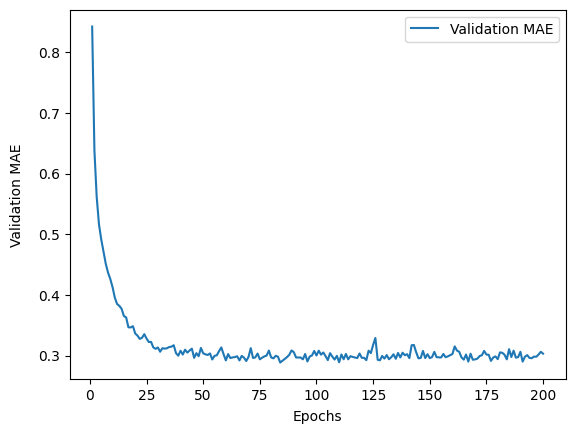

In [21]:
# Set the index of the first epoch from which MAE will be plotted.
ifirst = 0

# Plot MAE vs epoch number.
fig, ax = plt.subplots()
ax.plot(range(ifirst+1, n_epochs+1), mean_MAE_history['NumPy'][ifirst:], label='Validation MAE')
ax.set_xlabel('Epochs', labelpad=5)  # Label for the x-axis.
ax.set_ylabel('Validation MAE', labelpad=10)  # Label for the y-axis.
ax.legend()  # Add a legend to help identify the plot.
fig.show()  # Display the plot.


#### Block 10:  Retrain the model, from the ground up and evaluate it.

In [23]:
# Set the number of epochs for training
n_epochs = 130

# Rebuild the model from scratch
model = build_model()

# Train the model using the training dataset with specified batch size and without verbose output
model.fit(x_train, y_train, epochs=n_epochs, batch_size=16, verbose=0)

# Evaluate the model on the test set to obtain Mean Squared Error (MSE) and Mean Absolute Error (MAE)
test_MSE, test_MAE = model.evaluate(x_test, y_test)

# Optionally, print the evaluation results for quick analysis
print(f"Test MSE: {test_MSE:.4f}, Test MAE: {test_MAE:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3292 - mean_absolute_error: 0.3644  
Test MSE: 0.3247, Test MAE: 0.3495


#### Block 11:  Make predictions using the retrained model.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


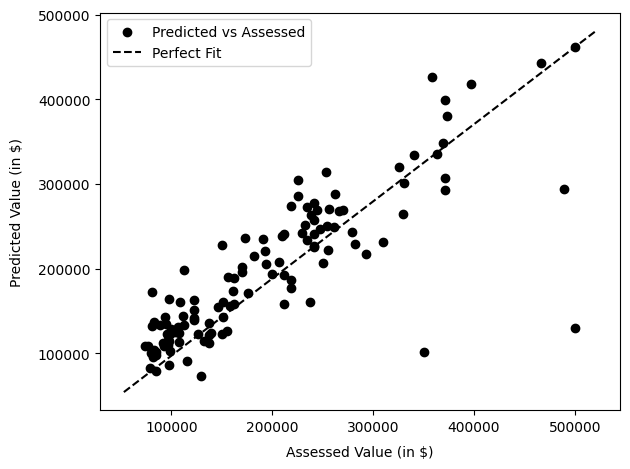

In [24]:
# Set the scale factor for plotting.
plot_sf = model_sf

# Predict house values using the features of the testing dataset and adjust by the scale factor.
predicted_values = model.predict(x_test) * plot_sf

# Adjust the true assessed values by the scale factor for consistent scaling in the plot.
assessed_values = y_test * plot_sf

# Create a scatter plot of assessed values vs. predicted values to visualize model performance.
fig, ax = plt.subplots()
ax.scatter(assessed_values, predicted_values, color='black', label='Predicted vs Assessed')
# Add a dashed line to indicate perfect prediction alignment.
ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--', label='Perfect Fit')
ax.set_xlabel('Assessed Value (in $)', labelpad=8)  # Label for the x-axis.
ax.set_ylabel('Predicted Value (in $)', labelpad=10)  # Label for the y-axis.
ax.legend()  # Add a legend to identify plot elements.
fig.tight_layout()  # Adjust the layout to make room for label pads.
fig.show()  # Display the plot.